In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings
import pickle
import time
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans
import logging
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack
warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [4]:
np.random.seed(seed=37)

In [6]:
# Importing the database 

df = pd.read_csv("./Questions.csv", encoding="ISO-8859-1")

In [7]:
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [8]:
tags = pd.read_csv("./Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [9]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [11]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [12]:
tags['Tag'] = tags['Tag'].astype(str)

In [13]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [14]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [15]:
grouped_tags.reset_index()


,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [16]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [17]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [18]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [19]:
df = df.merge(grouped_tags_final, on='Id')

In [20]:
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Refiltering posts based on score for computational purposes, as well as posts with less score are poorly written

In [21]:
new_df = df[df['Score']>5]

Text(0.5, 1.0, 'Ratio of missing values per columns')

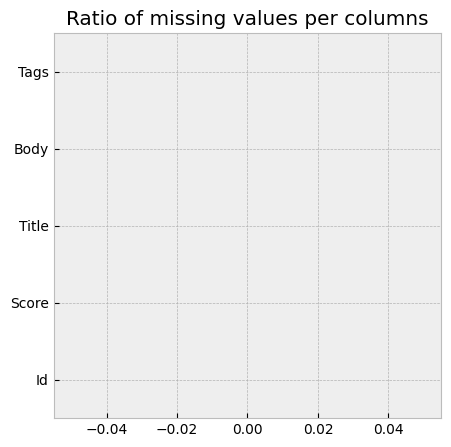

In [22]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [26]:
new_df.isnull().sum(axis = 0)

Id       0
Score    0
Title    0
Body     0
Tags     0
dtype: int64

In [27]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


Now we only need 3 columns: Body, Title and Tags.

In [28]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

In [30]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


cleaning tags column

In [31]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [32]:
new_df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself

In [33]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [35]:
len(all_tags)

224129

In [36]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [37]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)

tags_features = [word[0] for word in frequencies_words]

In [39]:
tags_features[:10]

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios']

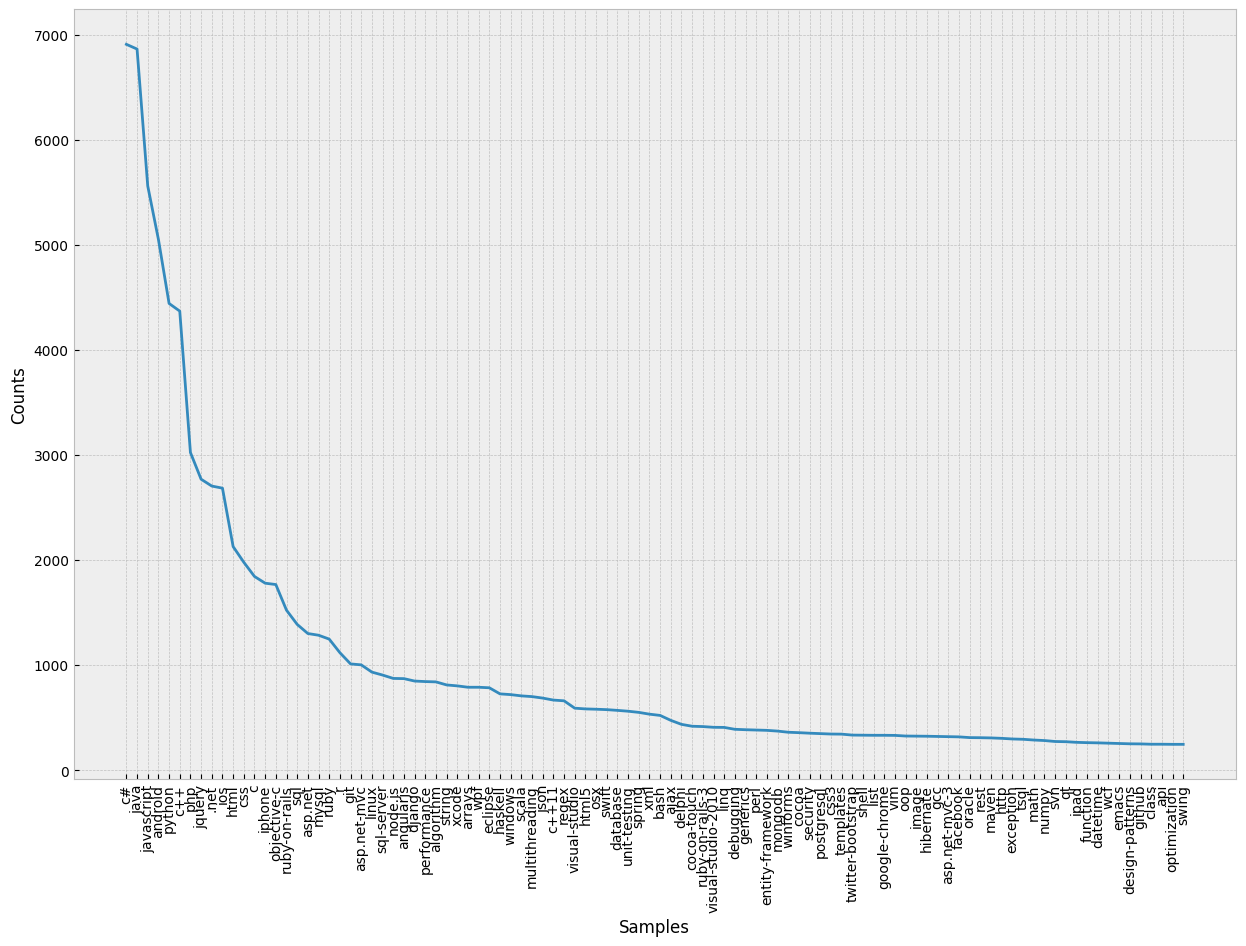

<Axes: xlabel='Samples', ylabel='Counts'>

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [41]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [42]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [43]:
new_df.shape

(72950, 3)

In [44]:
new_df.dropna(subset=['Tags'], inplace=True)

In [45]:
new_df.shape

(63167, 3)

Now lets clean body

In the next two columns: Body and Title, I'll use lots of text processing:

Removing html format \
Lowering text\
Transforming abbreviations\
Removing punctuation (but keeping words like c# since it's the most popular tag)\
Lemmatizing words\
Removing stop words

In [46]:
new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [47]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [48]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [49]:
token=ToktokTokenizer()

In [50]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [52]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [53]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [54]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [55]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [58]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [59]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [62]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x))

Here I'll just use some LDA to see if shows any paterns in words and the main topics.

In [63]:
no_topics = 20

In [64]:
text = new_df['Body']

In [66]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [67]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [72]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [74]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names_out(), no_top_words)

--------------------------------------------
Topic 0:
android bean layoutwidth layoutheight textview spring item wrapcontent matchparent name
--------------------------------------------
--------------------------------------------
Topic 1:
file run command install use instal studio project directory import
--------------------------------------------
--------------------------------------------
Topic 2:
public class void new string object return method private static
--------------------------------------------
--------------------------------------------
Topic 3:
thread exception task video catch process block device queue run
--------------------------------------------
--------------------------------------------
Topic 4:
git width height branch commit plot image size position div
--------------------------------------------
--------------------------------------------
Topic 5:
activity intent alloc bundle nslog person graph savedinstancestate eandroidruntime android
--------------

Now our data is almost ready to be put into a classifier. I just need to:

Binarize the tags\
Use a TFIDF for body and Title The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern :token_pattern=r"(?u)\S\S+"

In [75]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [76]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [77]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [78]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [79]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

2.2 One vs Rest

To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification

In [81]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [82]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 0.0
Hamming loss: 1.5717112553427262
---
Clf:  SGDClassifier
Jacard score: 43.798348372117566
Hamming loss: 1.014168117777426
---
Clf:  LogisticRegression
Jacard score: 45.55392855258298
Hamming loss: 1.013614057305683
---
Clf:  MultinomialNB
Jacard score: 36.326560226750196
Hamming loss: 1.1992243153395599
---
Clf:  LinearSVC
Jacard score: 49.46546356392803
Hamming loss: 1.0050656957416495
---
Clf:  Perceptron
Jacard score: 44.46913845481203
Hamming loss: 1.5411587779009024
---
Clf:  PassiveAggressiveClassifier
Jacard score: 46.454276819165216
Hamming loss: 1.334889979420611
---


In [83]:
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)

print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 45.9367956459139
Hamming loss: 1.4091340826341618
---


In [84]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 41.93762862118094
Hamming loss: 1.0637961057463987
---


2.5 GridSearch CV on the best classifier

In [86]:
param_grid = {'estimator__C':[1,10,100,1000]
              }

In [87]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START estimator__C=1..............................................
[CV 1/5; 1/4] END ..............estimator__C=1;, score=48.843 total time=  11.9s
[CV 2/5; 1/4] START estimator__C=1..............................................
[CV 2/5; 1/4] END ..............estimator__C=1;, score=49.203 total time=  11.0s
[CV 3/5; 1/4] START estimator__C=1..............................................
[CV 3/5; 1/4] END ..............estimator__C=1;, score=48.922 total time=  14.7s
[CV 4/5; 1/4] START estimator__C=1..............................................
[CV 4/5; 1/4] END ..............estimator__C=1;, score=47.716 total time=  15.0s
[CV 5/5; 1/4] START estimator__C=1..............................................
[CV 5/5; 1/4] END ..............estimator__C=1;, score=48.760 total time=  15.0s
[CV 1/5; 2/4] START estimator__C=10.............................................
[CV 1/5; 2/4] END .............estimator__C=10;, 

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 10, 100, 1000]},
             scoring=make_scorer(avg_jacard), verbose=10)

In [88]:
CV_svc.best_params_

{'estimator__C': 1}

In [129]:
best_model =  CV_svc.best_estimator_
best_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1))

In [130]:
y_pred = best_model.predict(X_test)
predict_proba_dist = best_model.decision_function(X_test)
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
y_score = []
for eachArr in predict_proba_dist:
    y_score.append(softmax(eachArr))
print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 49.46546356392803
Hamming loss: 1.0050656957416495
---


Printing metrics for our best model

In [131]:
def score_avg(y_pred, y_test):
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    hamming = hamming_loss(y_test, y_pred)
    jacard = jaccard_score(y_test, y_pred, average='micro')

    print("[PROGRAM]: classifier -> LinearSVC")
    print("[PROGRAM]: avg precision: {}".format(precision))
    print("[PROGRAM]: avg recall: {}".format(recall))
    print("[PROGRAM]: avg f1-score: {}".format(f1))
    print("[PROGRAM]: avg hamming loss: {}".format(hamming))
    print("[PROGRAM]: avg jacard score: {}".format(jacard))

    return [precision, recall, f1, hamming, jacard]

def score_per_tag(y_pred, y_test):
    hamming = []
    jaccard = []
    precision, recall, fscore, support = score(y_test, y_pred)
    for i, (test, pred) in enumerate(zip(y_test.T, y_pred.T)):
        hamming.append(hamming_loss(test, pred))
        jaccard.append(jaccard_score(test,pred))

    # DEBUG
    # print(len(precision))
    # print(len(recall))
    # print(len(fscore))
    # print(len(support))
    # print(len(hamming))
    # print(len(jaccard))
    # print(len(y_classes))

    return pd.DataFrame(data=[precision, recall, fscore, support, hamming, jaccard],
                         index=["Precision", "Recall", "F-1 score", "True count", "Hamming loss", "Jaccard score"],
                         columns=y_classes_names)


In [132]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_recall_fscore_support as score

In [133]:
metrics_avg = score_avg(y_pred, y_test)
metrics_per_tag = score_per_tag(y_pred, y_test)
print(metrics_per_tag)

[PROGRAM]: classifier -> LinearSVC
[PROGRAM]: avg precision: 0.7881349110520808
[PROGRAM]: avg recall: 0.4930754897517248
[PROGRAM]: avg f1-score: 0.6066294919454771
[PROGRAM]: avg hamming loss: 0.010050656957416495
[PROGRAM]: avg jacard score: 0.435368402330028
                     .net       ajax   algorithm      android   angularjs  \
Precision        0.652778   0.730769    0.727273     0.952169    0.931298   
Recall           0.171846   0.408602    0.476190     0.803002    0.663043   
F-1 score        0.272069   0.524138    0.575540     0.871247    0.774603   
True count     547.000000  93.000000  168.000000  1066.000000  184.000000   
Hamming loss     0.039813   0.005461    0.009340     0.020025    0.005620   
Jaccard score    0.157454   0.355140    0.404040     0.771867    0.632124   

                     api      arrays     asp.net  asp.net-mvc  asp.net-mvc-3  \
Precision       0.529412    0.525000    0.706897     0.694656       0.277778   
Recall          0.169811    0.362069 

In [134]:
top_ten_tags = ["javascript", "java", "c#", "php", "android", "jquery", "python", "html", "c++", "ios"]

In [135]:
top_ten_tags = ["javascript", "java", "c#", "php", "android", "jquery", "python", "html", "c++", "ios"]
print(metrics_per_tag[top_ten_tags])
print(metrics_per_tag[top_ten_tags].apply(np.mean, axis=1))

                javascript         java           c#         php      android  \
Precision         0.799472     0.843784     0.802589    0.898477     0.952169   
Recall            0.537234     0.563971     0.531808    0.594958     0.803002   
F-1 score         0.642630     0.676069     0.639725    0.715875     0.871247   
True count     1128.000000  1360.000000  1399.000000  595.000000  1066.000000   
Hamming loss      0.053348     0.058176     0.066329    0.022242     0.020025   
Jaccard score     0.473438     0.510652     0.470291    0.557480     0.771867   

                   jquery      python        html         c++         ios  
Precision        0.839907    0.922713    0.558140    0.873303    0.744807  
Recall           0.648746    0.673963    0.340426    0.666283    0.464815  
F-1 score        0.732053    0.778961    0.422907    0.755875    0.572406  
True count     558.000000  868.000000  423.000000  869.000000  540.000000  
Hamming loss     0.020975    0.026278    0.031107   

In [136]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

.net
[[12037    50]
 [  453    94]]

ajax
[[12527    14]
 [   55    38]]

algorithm
[[12436    30]
 [   88    80]]

android
[[11525    43]
 [  210   856]]

angularjs
[[12441     9]
 [   62   122]]

api
[[12573     8]
 [   44     9]]

arrays
[[12403    57]
 [  111    63]]

asp.net
[[12342    34]
 [  176    82]]

asp.net-mvc
[[12403    40]
 [  100    91]]

asp.net-mvc-3
[[12564    13]
 [   52     5]]

bash
[[12515    12]
 [   56    51]]

c
[[12214    64]
 [  195   161]]

c#
[[11052   183]
 [  655   744]]

c++
[[11681    84]
 [  290   579]]

c++11
[[12450    34]
 [  103    47]]

class
[[12582     4]
 [   46     2]]

cocoa
[[12552     5]
 [   76     1]]

cocoa-touch
[[12532     8]
 [   92     2]]

css
[[12177    83]
 [  137   237]]

css3
[[12558    16]
 [   50    10]]

database
[[12509    23]
 [   78    24]]

datetime
[[12573    15]
 [   35    11]]

debugging
[[12531    19]
 [   56    28]]

delphi
[[12542     2]
 [   46    44]]

design-patterns
[[12576     8]
 [   37    13]]

django
[[1246

In [140]:
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i,:])[-10:]
        print("--------------------------------------------")
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        print("--------------------------------------------")

In [141]:
feature_names = vectorizer_X1.get_feature_names_out() + vectorizer_X2.get_feature_names_out()

Another MOdel try

In [ ]:
def score_avg(y_pred, y_test):
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    hamming = hamming_loss(y_test, y_pred)
    jacard = jaccard_score(y_test, y_pred, average='micro')

    print("[PROGRAM]: classifier -> LinearSVC")
    print("[PROGRAM]: avg precision: {}".format(precision))
    print("[PROGRAM]: avg recall: {}".format(recall))
    print("[PROGRAM]: avg f1-score: {}".format(f1))
    print("[PROGRAM]: avg hamming loss: {}".format(hamming))
    print("[PROGRAM]: avg jacard score: {}".format(jacard))

    return [precision, recall, f1, hamming, jacard]
def score_per_tag(y_pred, y_test):
    hamming = []
    jaccard = []
    precision, recall, fscore, support = score(y_test, y_pred)
    for i, (test, pred) in enumerate(zip(y_test.T, y_pred.T)):
        hamming.append(hamming_loss(test, pred))
        jaccard.append(jaccard_score(test,pred))

    # DEBUG
    # print(len(precision))
    # print(len(recall))
    # print(len(fscore))
    # print(len(support))
    # print(len(hamming))
    # print(len(jaccard))
    # print(len(y_classes))

    return pd.DataFrame(data=[precision, recall, fscore, support, hamming, jaccard],
                         index=["Precision", "Recall", "F-1 score", "True count", "Hamming loss", "Jaccard score"],
                         columns=y_classes_names)

In [148]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier

In [149]:
classifier = CalibratedClassifierCV(LinearSVC(verbose=0))
clf = MultiOutputClassifier(classifier)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

In [150]:
metrics_avg = score_avg(y_pred, y_test)
metrics_per_tag = score_per_tag(y_pred, y_test)
print(metrics_per_tag)

[PROGRAM]: classifier -> LinearSVC
[PROGRAM]: avg precision: 0.8457109959700633
[PROGRAM]: avg recall: 0.44387369693307144
[PROGRAM]: avg f1-score: 0.5821856732388784
[PROGRAM]: avg hamming loss: 0.010013455754313757
[PROGRAM]: avg jacard score: 0.4106219426974144
                     .net       ajax   algorithm      android   angularjs  \
Precision        0.683333   0.743590    0.864198     0.959276    0.967480   
Recall           0.149909   0.311828    0.416667     0.795497    0.646739   
F-1 score        0.245877   0.439394    0.562249     0.869744    0.775244   
True count     547.000000  93.000000  168.000000  1066.000000  184.000000   
Hamming loss     0.039813   0.005857    0.008628     0.020104    0.005461   
Jaccard score    0.140171   0.281553    0.391061     0.769510    0.632979   

                     api      arrays     asp.net  asp.net-mvc  asp.net-mvc-3  \
Precision       0.250000    0.608108    0.783784     0.765306       0.666667   
Recall          0.018868    0.25862

In [151]:
################################ METRICS ON TOP TEN TAGS
top_ten_tags = ["javascript", "java", "c#", "php", "android", "jquery", "python", "html", "c++", "ios"]
print(metrics_per_tag[top_ten_tags])
print(metrics_per_tag[top_ten_tags].apply(np.mean, axis=1))

                javascript         java           c#         php      android  \
Precision         0.806078     0.851305     0.826790    0.921833     0.959276   
Recall            0.493794     0.551471     0.511794    0.574790     0.795497   
F-1 score         0.612424     0.669344     0.632230    0.708075     0.869744   
True count     1128.000000  1360.000000  1399.000000  595.000000  1066.000000   
Hamming loss      0.055802     0.058651     0.065933    0.022321     0.020104   
Jaccard score     0.441363     0.503018     0.462234    0.548077     0.769510   

                   jquery      python        html         c++         ios  
Precision        0.873418    0.931148    0.618497    0.890499    0.767273  
Recall           0.618280    0.654378    0.252955    0.636364    0.390741  
F-1 score        0.724029    0.768606    0.359060    0.742282    0.517791  
True count     558.000000  868.000000  423.000000  869.000000  540.000000  
Hamming loss     0.020817    0.027070    0.030236   

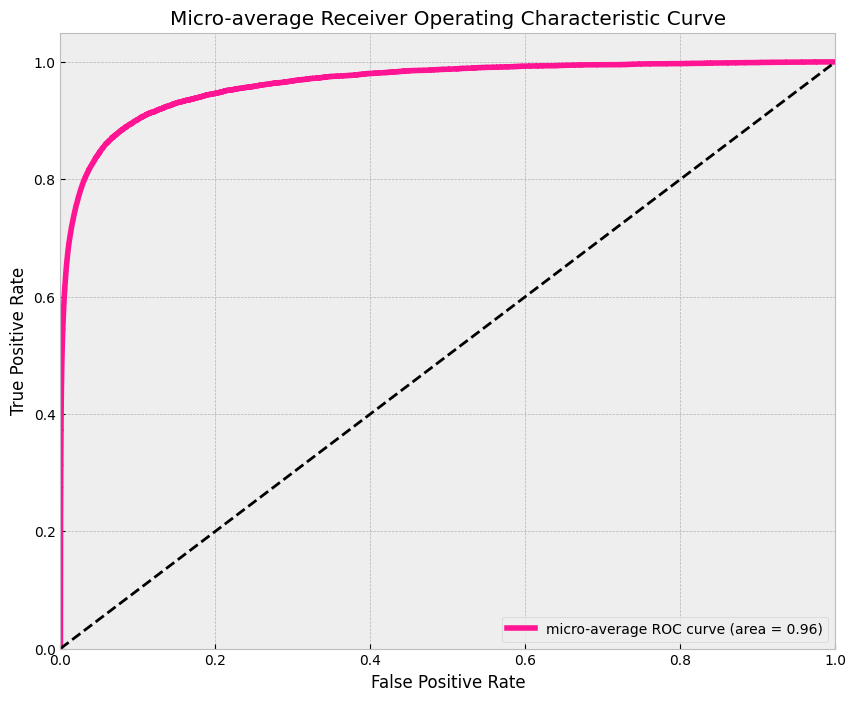

In [152]:
def plot_micro_average_roc(y_test, y_score):
    # setting up the plot
    # first aggregate all false positive rates
    # then interpolate all ROC curves at these points
    # finally average it and compute AUC
    # compute micro-average ROC curve and ROC area
    # plot ROC curve

    plt.figure(figsize=(10, 8))
    lw = 2 
    y_test_ravel = y_test.ravel()
    y_score_ravel = np.array([prob[:, 1] for prob in y_score]).T.ravel()
    fpr, tpr, _ = roc_curve(y_test_ravel, y_score_ravel)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc),
             color='deeppink', linestyle='-', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
plot_micro_average_roc(y_test, y_score)

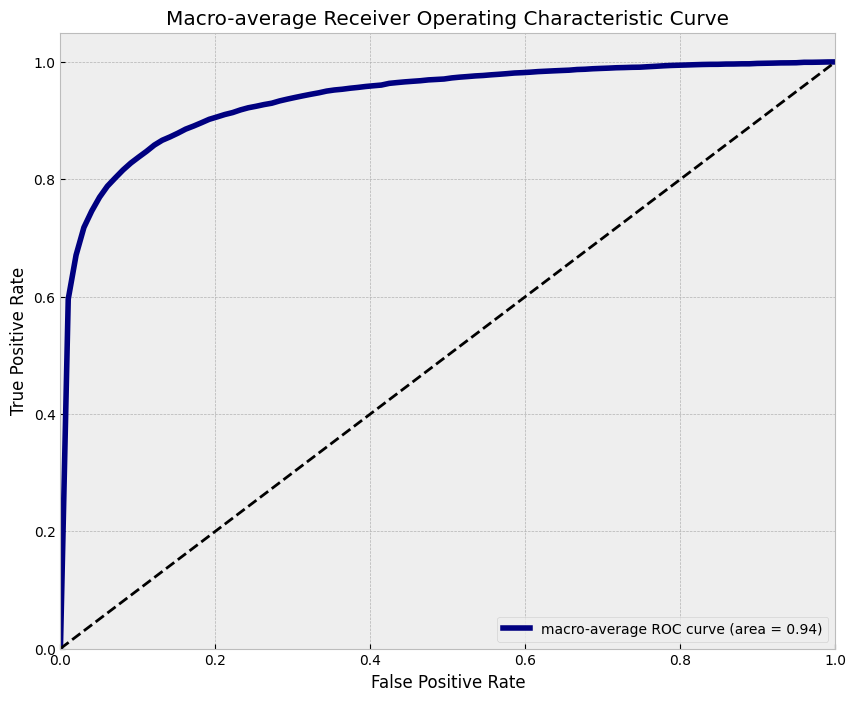

In [153]:
def plot_macro_average_roc(y_test, y_score, n_classes):
    # setting up the plot
    # first aggregate all false positive rates
    # then interpolate all ROC curves at these points
    # finally average it and compute AUC
    # compute macro-average ROC curve and ROC area
    # plot ROC curve

    plt.figure(figsize=(10, 8))
    lw = 2 
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = 0.0
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[i][:, 1])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
    mean_tpr /= n_classes
    roc_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr,
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc),
             color='navy', linestyle='-', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-average Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

    plt.show()


n_classes = y_test.shape[1]
plot_macro_average_roc(y_test, y_score, n_classes)


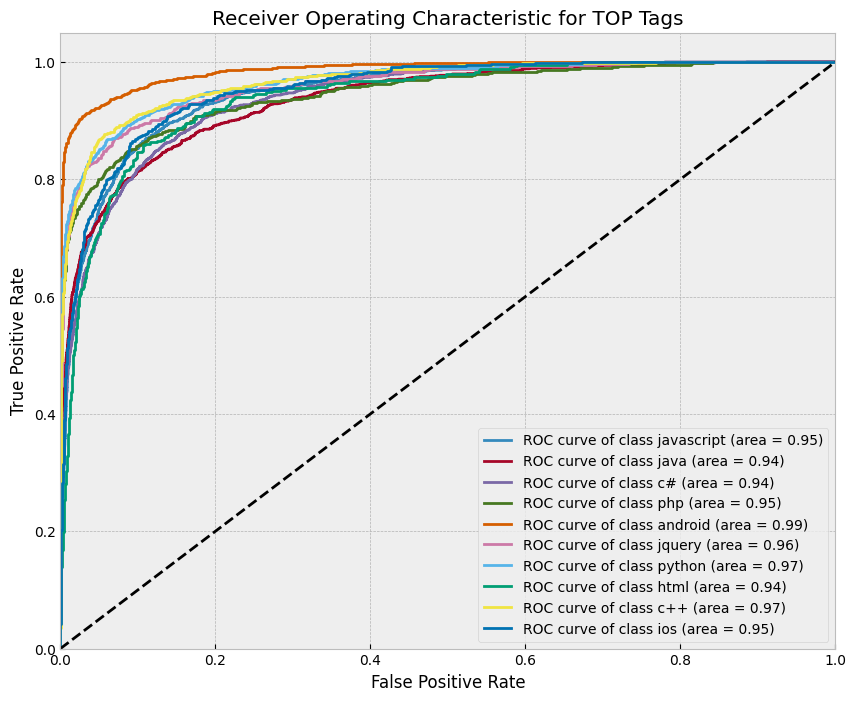

In [154]:
def plot_roc_curve(y_test, y_score, classes):
    plt.figure(figsize=(10, 8))
    lw = 2 
    for i, label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[i][:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, 
                 lw=lw, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for TOP Tags')
    plt.legend(loc="lower right")
    plt.show()

top_tags_index = [list(y_classes_names).index(tag) for tag in top_ten_tags]
y_test_top_tags = y_test[:, top_tags_index]
y_score_top_tags = [y_score[i] for i in top_tags_index]
plot_roc_curve(y_test_top_tags, y_score_top_tags, top_ten_tags)



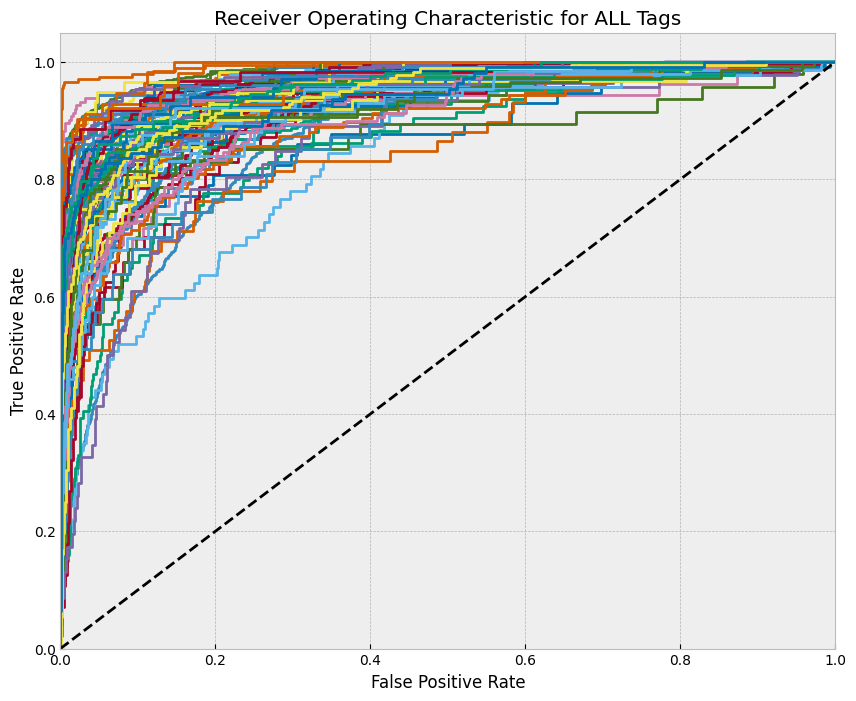

In [155]:
def plot_roc_curve(y_test, y_score, classes):

    plt.figure(figsize=(10, 8))
    lw = 2  
    for i, label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[i][:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, 
                 lw=lw, 
                 # label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc)
                 )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for ALL Tags')
    plt.show()

tags_index = [list(y_classes_names).index(tag) for tag in y_classes_names]
y_test_tags = y_test[:, tags_index]
y_score_tags = [y_score[i] for i in tags_index]
plot_roc_curve(y_test_tags, y_score_tags, y_classes_names)